In [1]:
import numpy as np
from math import ceil
from typing import List, Tuple
import matplotlib.pyplot as plt

In [2]:
# generate some arrival times with fixed intervals
max_t = 10
num_obs = 5
num_evtypes = 3
iats_d = {k: k+1 for k in range(num_evtypes)}

In [3]:
# actual data should look something like this
arrivaltimes = [
    [list(range(d, max_t, v)) for k, v in iats_d.items()]
    for d in range(num_obs)
]

In [4]:
# arrival times for 0-th replicate
arrivaltimes[0]

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [0, 2, 4, 6, 8], [0, 3, 6, 9]]

In [5]:
def get_tsvalues(t: int, arrivaltimes: List[int]) -> Tuple[int, int]:
    '''return (time_since_event, time_to_event)'''
    tse_candidates = [t-v for v in arrivaltimes if t >= v]
    tte_candidates = [v-t for v in arrivaltimes if v > t]
    return (
        min(tse_candidates) if len(tse_candidates) > 0 else None, 
        min(tte_candidates) if len(tte_candidates) > 0 else None,
    )

def get_indicators(tse: int, tte: int) -> Tuple[int, int]:
    '''return (tse is None, tte is None)'''
    prefirst = tse is None
    postlast = tte is None
    return prefirst, postlast

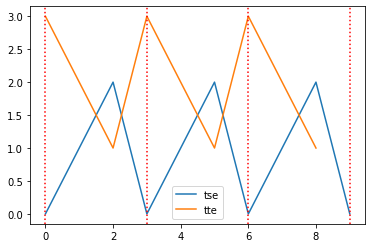

In [6]:
# demo of tse, tte
arrt = arrivaltimes[0][2]
tsvalues = [get_tsvalues(t, arrt) for t in range(max_t)]
tse_l, tte_l = zip(*tsvalues)

plt.plot(tse_l, label='tse')
plt.plot(tte_l, label='tte')
for t in arrt:
    plt.axvline(t, ls=':', color='red')

plt.legend()
plt.show()

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
def get_input_t(t: int, arrivaltimes: list, training: bool = False) -> list:
    '''return nested list of shape (num_obs, num_evtypes, [tse, tte, prefirst, postlast]) 
    representing time series values at each time t for all observations and event types'''
    # len(input_t) == num_obs
    input_t = []
    for arrt_obs in arrivaltimes:
        # len(input_type) == num_evtypes
        input_type = []
        for arrt_type in arrt_obs:
            tse, tte = get_tsvalues(t, arrt_type)
            prefirst, postlast = get_indicators(tse, tte)
            resl = [
                # tse, tte, prefirst, postlast
                -1 if prefirst else tse, 
                -1 if postlast else tte,
                1 if prefirst else 0,
                1 if postlast else 0,
            ] if not training else [
                # tse, prefirst
                -1 if prefirst else tse, 
                1 if prefirst else 0,
            ]
            input_type.append(resl)
        input_t.append(input_type)
    return input_t

In [9]:
print (
    'num_obs: {}, num_evtypes: {}, (tse, tte, prefirst, postlast): {}'\
    .format(num_obs, num_evtypes, 4)
)

for t in range(max_t):
    
    input_t = get_input_t(t, arrivaltimes)
    print ('t: {}, shape: {}, input_t[0][2]: {}'.format(t, np.array(input_t).shape, input_t[0][2]))

num_obs: 5, num_evtypes: 3, (tse, tte, prefirst, postlast): 4
t: 0, shape: (5, 3, 4), input_t[0][2]: [0, 3, 0, 0]
t: 1, shape: (5, 3, 4), input_t[0][2]: [1, 2, 0, 0]
t: 2, shape: (5, 3, 4), input_t[0][2]: [2, 1, 0, 0]
t: 3, shape: (5, 3, 4), input_t[0][2]: [0, 3, 0, 0]
t: 4, shape: (5, 3, 4), input_t[0][2]: [1, 2, 0, 0]
t: 5, shape: (5, 3, 4), input_t[0][2]: [2, 1, 0, 0]
t: 6, shape: (5, 3, 4), input_t[0][2]: [0, 3, 0, 0]
t: 7, shape: (5, 3, 4), input_t[0][2]: [1, 2, 0, 0]
t: 8, shape: (5, 3, 4), input_t[0][2]: [2, 1, 0, 0]
t: 9, shape: (5, 3, 4), input_t[0][2]: [0, -1, 0, 1]


In [10]:
print (
    'training...\nnum_obs: {}, num_evtypes: {}, (tse, prefirst): {}'\
    .format(num_obs, num_evtypes, 2)
)

for t in range(max_t):
    
    input_t = get_input_t(t, arrivaltimes, training=True)
    print ('t: {}, shape: {}, input_t[0][2]: {}'.format(t, np.array(input_t).shape, input_t[0][2]))

training...
num_obs: 5, num_evtypes: 3, (tse, prefirst): 2
t: 0, shape: (5, 3, 2), input_t[0][2]: [0, 0]
t: 1, shape: (5, 3, 2), input_t[0][2]: [1, 0]
t: 2, shape: (5, 3, 2), input_t[0][2]: [2, 0]
t: 3, shape: (5, 3, 2), input_t[0][2]: [0, 0]
t: 4, shape: (5, 3, 2), input_t[0][2]: [1, 0]
t: 5, shape: (5, 3, 2), input_t[0][2]: [2, 0]
t: 6, shape: (5, 3, 2), input_t[0][2]: [0, 0]
t: 7, shape: (5, 3, 2), input_t[0][2]: [1, 0]
t: 8, shape: (5, 3, 2), input_t[0][2]: [2, 0]
t: 9, shape: (5, 3, 2), input_t[0][2]: [0, 0]


In [11]:
class LSTMTSSparse(nn.Module):
    
    def __init__(self, num_evtypes, max_t):
        super(LSTMTSSparse, self).__init__()
        self.num_evtypes = num_evtypes
        self.max_t = max_t
        # input_size – The number of expected features in the input x
        # hidden_size – The number of features in the hidden state h
        # num_layers – Number of recurrent layers. Default: 1
        # bidirectional – If True, becomes a bidirectional LSTM. Default: False
        self.lstm = nn.LSTM(
            input_size=num_evtypes*2, 
            hidden_size=num_evtypes, 
            num_layers=1, 
            bidirectional=False
        )
        
    def forward(self, arrivaltimes: List[List[int]]):
        num_obs = len(arrivaltimes)
        # (seq_len, batch, input_size)
        hidden = (
            torch.randn(1*1, num_obs, self.num_evtypes), 
            torch.randn(1*1, num_obs, self.num_evtypes),
        )
        output_l = []
        for t in range(self.max_t):
            input_t = torch.Tensor(get_input_t(t, arrivaltimes, training=True)).view(1, num_obs, -1)
            output_t, hidden = self.lstm(input_t, hidden)
            output_l.append(output_t)
        return torch.cat(output_l, dim=0)

In [12]:
def get_target(arrivaltimes):
    return torch.cat([
        torch.Tensor(get_input_t(t, arrivaltimes, training=False))[
            ...,[1]
        ].view(1, num_obs, -1) 
        for t in range(max_t)
    ])

In [13]:
loss_function = nn.MSELoss()
model = LSTMTSSparse(num_evtypes, max_t)
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [14]:
with torch.no_grad():
    print (loss_function(model(arrivaltimes), get_target(arrivaltimes)))

tensor(2.4707)


In [15]:
for epoch in range(5):  # again, normally you would NOT do 300 epochs, it is toy data
    model.zero_grad()
    loss = loss_function(model(arrivaltimes), get_target(arrivaltimes))
    loss.backward()
    optimizer.step()
    print (epoch, loss)

0 tensor(2.4268, grad_fn=<MseLossBackward>)
1 tensor(2.4447, grad_fn=<MseLossBackward>)
2 tensor(2.3734, grad_fn=<MseLossBackward>)
3 tensor(2.3856, grad_fn=<MseLossBackward>)
4 tensor(2.4201, grad_fn=<MseLossBackward>)


In [16]:
with torch.no_grad():
    print (loss_function(model(arrivaltimes), get_target(arrivaltimes)))

tensor(2.2708)
